In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/heestogram/Chatbot4Univ.git

Cloning into 'Chatbot4Univ'...
remote: Enumerating objects: 126545, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 126545 (delta 37), reused 96 (delta 27), pack-reused 126433
Receiving objects: 100% (126545/126545), 451.29 MiB | 18.76 MiB/s, done.
Resolving deltas: 100% (106174/106174), done.
Updating files: 100% (126432/126432), done.


In [ ]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 43.0 MB/s eta 0:00:00


In [ ]:
%cd /content/Chatbot4Univ/

/content/Chatbot4Univ


In [ ]:
okt=Okt()
okt.tagset

{'Adjective': '형용사',
 'Adverb': '부사',
 'Alpha': '알파벳',
 'Conjunction': '접속사',
 'Determiner': '관형사',
 'Eomi': '어미',
 'Exclamation': '감탄사',
 'Foreign': '외국어, 한자 및 기타기호',
 'Hashtag': '트위터 해쉬태그',
 'Josa': '조사',
 'KoreanParticle': '(ex: ㅋㅋ)',
 'Noun': '명사',
 'Number': '숫자',
 'PreEomi': '선어말어미',
 'Punctuation': '구두점',
 'ScreenName': '트위터 아이디',
 'Suffix': '접미사',
 'Unknown': '미등록어',
 'Verb': '동사'}

In [ ]:
from konlpy.tag import *
import pickle

class Preprocess:
    def __init__(self, word2index_dic='train_tools/dict/chatbot_dict.bin' ,userdic='user_dic.tsv'):
        if(word2index_dic != ''):
            f = open(word2index_dic, "rb")
            self.word_index = pickle.load(f)
            f.close()
            print("단어 사전 로드 완료..")
        else:
            self.word_index = None
            print("단어 사전 로드 실패..")

        self.okt = Okt()

        # 제외할 품사
        self.exclusion_tags = [
            'Exclamation', 'Hashtag', 'KoreanParticle',
            'Punctuation', 'ScressnName', 'Unknown'
        ]

    # 형태소 분석기 POS 태거
    def pos(self, sentence):
        return self.okt.pos(sentence)

    # 불용어 제거 후 필요한 품사 정보만 가져오기
    def get_keywords(self, pos, without_tag=False):
        f = lambda x: x in self.exclusion_tags
        word_list = []
        for p in pos:
            if f(p[1]) is False:
                word_list.append(p if without_tag is False else p[0])
        return word_list

    # 키워드를 단어 인덱스 시퀀스로 변환
    def get_wordidx_sequence(self, keywords):
        if self.word_index is None:
            return []
        w2i = []
        for word in keywords:
            try:
                w2i.append(self.word_index[word])
            except KeyError:
                # 해당 단어가 사전에 없는 경우 OOV 처리
                w2i.append(self.word_index['OOV'])
        return w2i

In [ ]:
sent = "zoom이 보이지 않습니다. 어떻게 하면 메뉴에 보이나요?"

# 전처리 객체 생성
p = Preprocess(userdic='utils/user_dic.tsv')

# 형태소 분석기 실행
pos = p.pos(sent)

# 품사 태그와 같이 키워드 출력
ret = p.get_keywords(pos, without_tag=False)
print(ret)

# 품사 태그 없이 키워드 출력
ret = p.get_keywords(pos, without_tag=True)
print(ret)

단어 사전 로드 완료..
[('zoom', 'Alpha'), ('이', 'Noun'), ('보이지', 'Noun'), ('않습니다', 'Verb'), ('어떻게', 'Adjective'), ('하면', 'Verb'), ('메뉴', 'Noun'), ('에', 'Josa'), ('보이나요', 'Verb')]
['zoom', '이', '보이지', '않습니다', '어떻게', '하면', '메뉴', '에', '보이나요']


In [ ]:
# 단어 사전 파일 생성 코드입니다.
# 이미 디렉토리에 save 되어 있어서 굳이 실행할 필요 없음
# 챗봇에 사용하는 사전 파일
from tensorflow.keras import preprocessing
import pickle
import pandas as pd

# 말뭉치 데이터 읽어오기
movie_review = pd.read_csv('변형데이터/영화리뷰.csv')
purpose = pd.read_csv('변형데이터/용도별목적대화데이터.csv')
topic = pd.read_csv('변형데이터/주제별일상대화데이터.csv')
common_sense = pd.read_csv('변형데이터/일반상식.csv')

movie_review.dropna(inplace=True)
purpose.dropna(inplace=True)
topic.dropna(inplace=True)
common_sense.dropna(inplace=True)

text1 = list(movie_review['document'])
text2 = list(purpose['text'])
text3 = list(topic['text'])
text4 = list(common_sense['query']) + list(common_sense['answer'])

corpus_data = text1 + text2 + text3 + text4

# 말뭉치 데이터에서 키워드만 추출해서 사전 리스트 생성
p = Preprocess()
dict = []
for c in corpus_data:
    pos = p.pos(c)
    for k in pos:
        dict.append(k[0])

# 사전에 사용될 word2index 생성
# 사전의 첫 번째 인덱스에는 OOV 사용
tokenizer = preprocessing.text.Tokenizer(oov_token='OOV', num_words=100000)
tokenizer.fit_on_texts(dict)
word_index = tokenizer.word_index
print(len(word_index))

# 사전 파일 생성
f = open("chatbot_dict.bin", "wb")
try:
    pickle.dump(word_index, f)
except Exception as e:
    print(e)
finally:
    f.close()

In [ ]:
import pickle

# 단어 사전 불러오기
f = open("train_tools/dict/chatbot_dict.bin", "rb")
word_index = pickle.load(f)
f.close()

sent = "안녕하세요. 고려대학교 사회학과에 다니고 있는 김희준입니다"

# 전처리 객체 생성
p = Preprocess(userdic='utils/user_dic.tsv')

# 형태소 분석기 실행
pos = p.pos(sent)

# 품사 태그 없이 키워드 출력
keywords = p.get_keywords(pos, without_tag=True)
for word in keywords:
    try:
        print(word, word_index[word])
    except KeyError:
        # 해당 단어가 사전에 없는 경우 OOV 처리
        print(word, word_index['OOV'])

단어 사전 로드 완료..
안녕하세요 137
고려대학교 17670
사회 829
학과 3460
에 10
다니고 1
있는 23977
김희준 1
입니다 21630


## 카테고리 분류 모델 만들기

In [ ]:
#data_ = pd.read_excel("/content/drive/MyDrive/bbcontest/maindata.xlsx")

In [ ]:
#data_['tags'].unique()

array(['메뉴바', '성적', 'lockdown browser', '시험', '협업툴', '청강', '출석', 'Zoom',
       '세종', '기타', 'turnitin', '과제', 'commons', '교수자', 'kaltura', '학습자',
       '조교권한', '로그인', '법정의무교육', '게시물', '데이터삭제', 'collaborate', '설문', '용량',
       '실시간강의', '이메일', '강의자료', '수강신청', '고대인클래스', '어플', '코스', '출석부',
       '이용환경관련', 'youtube', '한자시험', '녹화강의', '시스템오류', '메뉴', '기타교육',
       '수강소감설문', '공지사항', '표절검사', '관리자권한', '설정', 'ISC', '알람', '불만', 'IWC',
       '강의계획서', '블랙보드', '사용자등록', '컨텐츠오류', '오류', '포트폴리오', '유선문의', '서버오류',
       'learninghigh', 'voicethread', '채점', 'piazza', '쿠카이브', '퀴즈',
       '졸업생권한', '구블랙보드'], dtype=object)

In [ ]:
# 수업:0 성적:1 블랙보드 기능:2 도구:3 오류:4 기타:5

#data_['label'] = data_['tags'].apply(lambda x: 0 if x in ['강의계획서', '출석', '출석부','강의자료','청강','과제','수강신청','코스','녹화강의','교수자','학습자']
#                                 else (1 if x in ['성적', '채점', '시험','퀴즈']
#                                       else (2 if x in ['게시물', '공지사항','협업툴','설문','사용자 등록','메뉴바']
#                                             else(3 if x in ['Zoom','collaborate','lockdown browser','표절검사','turnitin','commons','youtube','kaltura']
#                                                  else(4 if x in ['로그인','콘텐츠오류','시스템오류'] else 5)))))


In [ ]:
#data_['label'].value_counts()

5    1223
0    1097
3     685
2     337
1     271
4     167
Name: label, dtype: int64

In [ ]:
#data = data_[['summary_text_q','label']]
#data.to_csv("/content/drive/MyDrive/bbcontest/train_data.csv", index=False)

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/bbcontest/train_data.csv")

In [ ]:
tokenizer = Okt()

In [ ]:
from tqdm import tqdm
import re
df_len = data.shape[0]
words_list = []
for i in range(df_len):
  words_list.append(re.sub('[^ㄱ-ㅎ가-힣a-zA-Z]', ' ',data['summary_text_q'][i]))

In [ ]:
data['summary_text_q'] = words_list

In [ ]:
data_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(text_)] for text_ in data['summary_text_q']]

exclusion_tags = [
            'Exclamation', 'Hashtag', 'KoreanParticle',
            'Punctuation', 'ScressnName', 'Unknown'
]

f = lambda x: x in exclusion_tags

data_list = []
for i in range(len(data_tokenized)):
        temp = []
        for j in range(len(data_tokenized[i])):
            if f(data_tokenized[i][j].split('/')[1]) is False:
                temp.append(data_tokenized[i][j].split('/')[0])
        data_list.append(temp)

In [ ]:
import numpy as np
num_tokens = [len(tokens) for tokens in data_list]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

토큰 길이 평균: 26.17200317544324
토큰 길이 최대: 154
토큰 길이 표준편차: 22.890400060017246


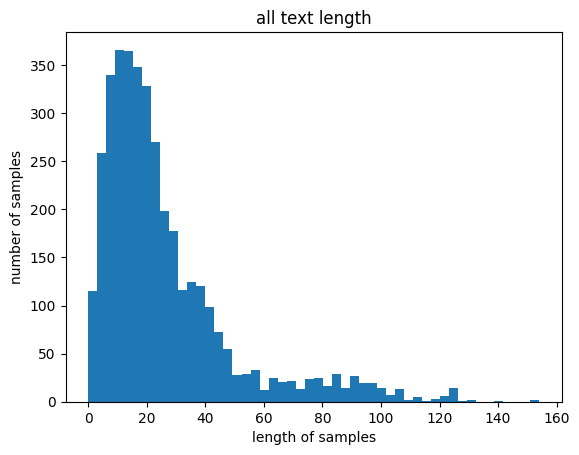

In [ ]:
import matplotlib.pyplot as plt
plt.title('all text length')
plt.hist(num_tokens, bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
select_length = 50

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1

    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(select_length, data_list)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.8907118285260651


In [ ]:
!pip uninstall tensorflow
!pip uninstall tensorboard
!pip uninstall tensorboard-data-server
!pip uninstall tensorboard-plugin-wit
!pip uninstall tensorflow-estimator
!pip uninstall tensorflow-intel
!pip uninstall tensorflow-io-gcs-filesystem
!pip uninstall keras

Found existing installation: tensorflow 2.11.1
Uninstalling tensorflow-2.11.1:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.11.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.11.1
Found existing installation: tensorboard 2.11.2
Uninstalling tensorboard-2.11.2:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/tensorboard-2.11.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorboard/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorboard-2.11.2
Found existing installation: tensorboard-data-server 0.6.1
Uninstalling tensorboard-data-server-0.6.1:
  Would remove:
    /usr/local/lib/

In [ ]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 59.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-au

In [ ]:
# 단어 시퀀스 벡터 크기
MAX_SEQ_LEN = 50

In [ ]:
def GlobalParams():
    global MAX_SEQ_LEN

# Import
import pandas as pd
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Conv1D, GlobalMaxPool1D, concatenate


# Load Data
data = pd.read_csv("/content/drive/MyDrive/bbcontest/train_data.csv")
text = data['summary_text_q'].tolist()
label = data['label'].tolist()

# Load preprocessor
p = Preprocess(word2index_dic='train_tools/dict/chatbot_dict.bin',
               userdic='utils/user_dic.tsv')

# Data preprocess
sequences = []
for sentence in text:
    pos = p.pos(sentence)
    keywords = p.get_keywords(pos, without_tag=True)
    seq = p.get_wordidx_sequence(keywords)
    sequences.append(seq)

# set padding length & pad to sequences
padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

# data to tensor
ds = tf.data.Dataset.from_tensor_slices((padded_seqs, label))
ds = ds.shuffle(len(text))

# set train & validation & test size
train_size = int(len(padded_seqs) * 0.7)
val_size = int(len(padded_seqs) * 0.2)
test_size = int(len(padded_seqs) * 0.1)

train_ds = ds.take(train_size).batch(100)
val_ds = ds.take(train_size).take(val_size).batch(100)
test_ds = ds.take(train_size + val_size).take(test_size).batch(100)

# Hyperparameter
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = len(p.word_index) + 1

# CNN model definition
input_layer = Input(shape=(MAX_SEQ_LEN, ))
embedding_layer = Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_SEQ_LEN)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

conv1 = Conv1D(
    filters=128,
    kernel_size=3,
    padding='valid',
    activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)

conv2 = Conv1D(
    filters=128,
    kernel_size=4,
    padding='valid',
    activation=tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPool1D()(conv2)

conv3 = Conv1D(
    filters=128,
    kernel_size=5,
    padding='valid',
    activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

concat = concatenate([pool1, pool2, pool3])

hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(6, name='logits')(dropout_hidden)
predictions = Dense(6, activation=tf.nn.softmax)(logits)

# CNN model create
model = Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train model
model.fit(train_ds, validation_data=val_ds, epochs=EPOCH, verbose=1)

# evaluate model
loss, accuracy = model.evaluate(test_ds, verbose=1)
print("Accuracy: %f" % (accuracy * 100))
print("loss : %f" % (loss))

acc_list.append(accuracy)

# save model
model.save('models/intent/intent_model.h5')

단어 사전 로드 완료..
Epoch 1/30
27/27 [==============================] - 24s 850ms/step - loss: 1.6286 - accuracy: 0.3047 - val_loss: 1.6006 - val_accuracy: 0.3258
Epoch 2/30
27/27 [==============================] - 22s 818ms/step - loss: 1.5870 - accuracy: 0.3346 - val_loss: 1.5805 - val_accuracy: 0.3748
Epoch 3/30
27/27 [==============================] - 22s 823ms/step - loss: 1.5463 - accuracy: 0.3898 - val_loss: 1.5010 - val_accuracy: 0.4940
Epoch 4/30
27/27 [==============================] - 25s 936ms/step - loss: 1.4577 - accuracy: 0.4397 - val_loss: 1.4004 - val_accuracy: 0.4821
Epoch 5/30
27/27 [==============================] - 22s 833ms/step - loss: 1.3376 - accuracy: 0.4870 - val_loss: 1.2237 - val_accuracy: 0.5470
Epoch 6/30
27/27 [==============================] - 24s 905ms/step - loss: 1.2074 - accuracy: 0.5270 - val_loss: 1.1066 - val_accuracy: 0.5695
Epoch 7/30
27/27 [==============================] - 23s 859ms/step - loss: 1.0744 - accuracy: 0.6121 - val_loss: 0.9351 - val_ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
val_acc_list=[0.3258,0.3748,0.4940,0.4821,0.5470,0.5695,0.7099,0.7497,0.8000,0.7907,0.8225,0.8450,0.8874,0.8742,0.9020,0.9073,0.9364,0.9351,0.9444,0.9656,0.9497,0.9603,0.9735,0.9629,0.9563,0.9762,0.9722,0.9755,0.9603,0.9775]
acc_list=[0.3047,0.3346,0.3898,0.4397,0.4870,0.5270,0.6121,0.6786,0.6994,0.7406,0.7698,0.7830,0.8034,0.8299,0.8345,0.8765,0.8586,0.8673,0.8703,0.8862,0.8991,0.8991,0.9127,0.9270,0.9176,0.9278,0.9338,0.9384,0.9342,0.9422]

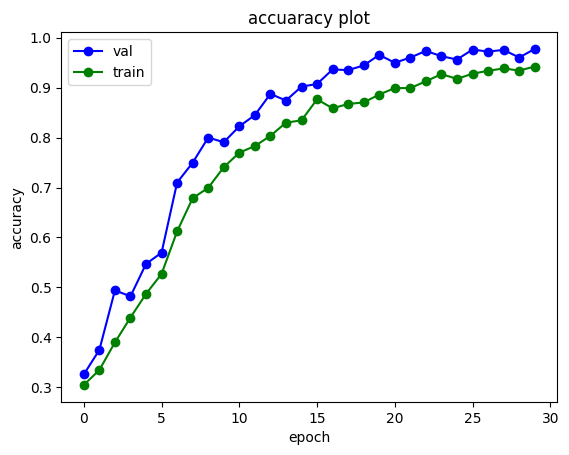

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#데이터 생성


#그래프생성
plt.plot(val_acc_list,color='blue',linestyle='-',marker='o', label="val")
plt.plot(acc_list,color='green',linestyle='-',marker='o', label="train")

#그래프 정보 설정
#plt.xlim(40, 80) #x축 범위
#plt.ylim(100, 200) #y축 범위
plt.xlabel('epoch') #x 라벨
plt.ylabel('accuracy') #y 라벨
plt.title("accuaracy plot") #그래프 이름
plt.legend()

#그래프 출력
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import preprocessing
import gc

# 카테고리 분류 모델 모듈
class IntentModel:
    def __init__(self, model_name, preprocess):

        # 카테고리 클래스별 레이블
        self.labels = {0: "수업", 1: "성적", 2: "블랙보드 기능", 3:"도구", 4:"오류", 5:"기타"}

        # 의도 분류 모델 불러오기
        self.model = load_model(model_name)

        # 챗봇 텍스트 전처리기
        self.p = preprocess

    # 카테고리 클래스 예측
    def predict_class(self, query):
        # 형태소 분석
        pos = self.p.pos(query)

        # 문장내 키워드 추출(불용어 제거)
        keywords = self.p.get_keywords(pos, without_tag=True)
        sequences = [self.p.get_wordidx_sequence(keywords)]

        # 패딩처리
        padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

        predict = self.model.predict(padded_seqs)
        predict_class = tf.math.argmax(predict, axis=1)
        return predict_class.numpy()[0]

In [ ]:
p = Preprocess(word2index_dic='train_tools/dict/chatbot_dict.bin',
               userdic='utils/user_dic.tsv')

intent = IntentModel(model_name='/content/drive/MyDrive/bbcontest/intent_model.h5', preprocess=p)

단어 사전 로드 완료..


In [ ]:
def category_classifier(query):
  predict = intent.predict_class(query)
  predict_label = intent.labels[predict]
  print("="*30)
  print("입력 질문 :",query)
  print("예측 카테고리 :", predict_label)

In [ ]:
text = "zoom 접속이 되지 않아요"
category_classifier(query=text)

text = "청강생 등록이 잘 되지 않습니다"
category_classifier(query=text)

text = "콜라보레이트 메뉴가 보이지 않아요"
category_classifier(query=text)

text = "녹화강의를 올려야 하는데 방법을 알려주세요"
category_classifier(query=text)

text = "법정의무교육, 성인지교육을 수강해야하는데 언제까지죠?"
category_classifier(query=text)

1/1 [==============================] - 0s 34ms/step
입력 질문 : zoom 접속이 되지 않아요
예측 카테고리 : 도구
1/1 [==============================] - 0s 28ms/step
입력 질문 : 청강생 등록이 잘 되지 않습니다
예측 카테고리 : 수업
1/1 [==============================] - 0s 28ms/step
입력 질문 : 콜라보레이트 메뉴가 보이지 않아요
예측 카테고리 : 블랙보드 기능
1/1 [==============================] - 0s 29ms/step
입력 질문 : 녹화강의를 올려야 하는데 방법을 알려주세요
예측 카테고리 : 수업
1/1 [==============================] - 0s 31ms/step
입력 질문 : 법정의무교육, 성인지교육을 수강해야하는데 언제까지죠?
예측 카테고리 : 기타


## 질의응답 chatbot 구현

In [ ]:
#qna_data = data_[['summary_text_q','summary_text_a','label']]
#qna_data.dropna(axis=0,inplace=True)
#qna_data.reset_index(drop=True, inplace=True)
#sum(qna_data['summary_text_q'].isnull())
#qna_data.to_csv("/content/drive/MyDrive/bbcontest/qna_data.csv", index=False)

<ipython-input-98-4e966ea10c5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qna_data.dropna(axis=0,inplace=True)


In [ ]:
qna_data = pd.read_csv("/content/drive/MyDrive/bbcontest/qna_data.csv")

In [ ]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.4 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=a1136f09bc621f39c0ffb56227d99a3892be567477cc0ab033f87e4659f13203
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import torch
from sentence_transformers import SentenceTransformer


train_file = "/content/drive/MyDrive/bbcontest/qna_data.csv"
model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

## 임베딩 굳이 안해도 됨. 임베딩 파일 깃헙 레포에 저장해놨음

df = pd.read_csv(train_file)
df['embedding_vector'] = df['summary_text_q'].progress_map(lambda x : model.encode(x))
df.to_excel("train_data_embedding.xlsx", index=False)

embedding_data = torch.tensor(df['embedding_vector'].tolist())
torch.save(embedding_data, 'train_tools/qna/embedding_data.pt')


class create_embedding_data:
    def __init__(self, preprocess, df):
        # 텍스트 전처리기
        self.p = preprocess

        # 질문 데이터프레임
        self.df = df

        # pre-trained SBERT
        self.model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

    def create_pt_file(self):
        # 질문 목록 리스트
        target_df = list(self.df['summary_text_q'])

        # 형태소 분석
        for i in range(len(target_df)):
            sentence = target_df[i]
            pos = self.p.pos(sentence)
            keywords = self.p.get_keywords(pos, without_tag=True)
            temp = ""
            for k in keywords:
                temp += str(k)
            target_df[i] = temp

        self.df['질문 전처리'] = target_df
        self.df['embedding_vector'] = self.df['질문 전처리'].progress_map(lambda x : self.model.encode(x))
        # self.df.to_excel("/Users/Home/Documents/GitHub/Chatbot4Univ/train_tools/qna/train_data_embedding.xlsx", index=False)
        embedding_data = torch.tensor(self.df['embedding_vector'].tolist())
        torch.save(embedding_data, 'train_tools/qna/embedding_data.pt')


In [ ]:
import torch
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
embedding_data = torch.load('train_tools/qna/embedding_data.pt')
df = pd.read_csv('/content/drive/MyDrive/bbcontest/qna_data.csv')

p = Preprocess(word2index_dic='train_tools/dict/chatbot_dict.bin',
               userdic='utils/user_dic.tsv')
intent = IntentModel(model_name='/content/drive/MyDrive/bbcontest/intent_model.h5', preprocess=p)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/967k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/336k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

단어 사전 로드 완료..


In [ ]:
def chatbot_answer(question):
  # 질문 예시 문장
  print("----어흥톡 상시 상담 ON----")
  sentence = question
  print("질문 문장 : ",sentence)
  sentence = sentence.replace(" ","")

  predict = intent.predict_class(sentence)
  predict_label = intent.labels[predict]
  print("예측 카테고리 :", predict_label)

  # 질문 예시 문장 인코딩 후 텐서화
  sentence_encode = model.encode(sentence)
  sentence_tensor = torch.tensor(sentence_encode)

  # 저장한 임베딩 데이터와의 코사인 유사도 측정
  cos_sim = util.cos_sim(sentence_tensor, embedding_data)

  # 선택된 질문 출력
  best_sim_idx = int(np.argmax(cos_sim))
  selected_qes = df['summary_text_q'][best_sim_idx]
  print(f"선택된 질문 = {selected_qes}")

  # 선택된 질문 문장에 대한 인코딩
  selected_qes_encode = model.encode(selected_qes)

  # 유사도 점수 측정
  score = np.dot(sentence_tensor,
                 selected_qes_encode) / (np.linalg.norm(
                     sentence_tensor) * np.linalg.norm(selected_qes_encode))
  print(f"선택된 질문과의 유사도 = {score}")

  # 답변
  answer = df['summary_text_a'][best_sim_idx]
  print(f"\n답변 : {answer}\n")


In [ ]:
question = "블랙보드의 출석확인 자율화가 어떤 시스템으로 이뤄지나요?"
chatbot_answer(question=question)

----어흥톡 상시 상담 ON----
질문 문장 :  블랙보드의 출석확인 자율화가 어떤 시스템으로 이뤄지나요?
1/1 [==============================] - 0s 33ms/step
예측 카테고리 : 수업
선택된 질문 = 혹시 블랙보드 자동 출석은 어디서 확인가능한가요?
선택된 질문과의 유사도 = 0.6756680011749268

답변 : 실시간 강의 출석을 말씀하시는 것일까요? 교수님께서 출석을 확인하시는 경우 로그를 보시고 수동으로 출석을 체크하시는 형태가 될 것 같습니다.



In [ ]:
question = "블랙보드 토론실에 올린 게시물을 삭제하는 방법은?"
chatbot_answer(question=question)

----어흥톡 상시 상담 ON----
질문 문장 :  블랙보드 토론실에 올린 게시물을 삭제하는 방법은?
1/1 [==============================] - 0s 37ms/step
예측 카테고리 : 블랙보드 기능
선택된 질문 = 블랙보드 토론실에 실수로 올린 게시물 삭제하는 방법이 있을까요?
선택된 질문과의 유사도 = 0.7514525651931763

답변 : 낭만호랭이의 경우 교수님이 사전에 설정해놓으신 옵션에 따라 수정 및 삭제가 불가능하실 수 있으므로 해당 과목의 교수님께 문의 부탁드립니다! 감사합니다, 건강 조심하시고 남은 하루도 좋은 하루 보내세요!



In [ ]:
question = "제출한 과제를 수정하고 싶습니다"
chatbot_answer(question=question)

----어흥톡 상시 상담 ON----
질문 문장 :  제출한 과제를 수정하고 싶습니다
1/1 [==============================] - 0s 20ms/step
예측 카테고리 : 수업
선택된 질문 = 이미 제출한 제출한 과제를 수정할 수 있나요?
선택된 질문과의 유사도 = 0.7578074932098389

답변 : 블랙보드에서 과제를 수정하는 것은 불가능하지만 교수님께서 제출 가능 횟수를 2회이상으로 설정해놓으신 경우에 한해 재제출만 가능하며 불가피하게 과제를 다시 제출하셔야 하는 경우 교수님께 직접 연락드리셔야 할 것 같다. 



In [ ]:
question = "분명 청강 문의를 드렸는데, 청강 과목이 블랙보드에서 삭제되어 있습니다."
chatbot_answer(question=question)

----어흥톡 상시 상담 ON----
질문 문장 :  분명 청강 문의를 드렸는데, 청강 과목이 블랙보드에서 삭제되어 있습니다.
1/1 [==============================] - 0s 37ms/step
예측 카테고리 : 수업
가장 높은 코사인 유사도 idx : 50
선택된 질문 = 정정기간이 다 지난 후 교수님께 청강 문의를 드려 청강생 등록을 했고, 오늘 오전까지도 블랙보드 상에 청강하는 강의가 다 있었으나, 오후 늦게 블랙보드에 들어가 보니 청강생 등록된 강의들이 일괄 삭제되어 있어서 문의 드리게 됐다.
선택된 질문과의 유사도 = 0.6967754364013672

답변 : 전체정정 이후 청강을 지속하지 않는 학생들이 많아진 만큼 교수님께 다시 한번 청강생 등록을 요청드리셔야 할 것 같습니다.



In [ ]:
question = "블랙보드의 출석확인 자율화가 어떤 시스템으로 이뤄지나요?"
chatbot_answer(question=question)

----어흥톡 상시 상담 ON----
질문 문장 :  블랙보드의 출석확인 자율화가 어떤 시스템으로 이뤄지나요?
1/1 [==============================] - 0s 48ms/step
예측 카테고리 : 수업
가장 높은 코사인 유사도 idx : 308
선택된 질문 = 혹시 블랙보드 자동 출석은 어디서 확인가능한가요?
선택된 질문과의 유사도 = 0.6756680011749268

답변 : 실시간 강의 출석을 말씀하시는 것일까요? 교수님께서 출석을 확인하시는 경우 로그를 보시고 수동으로 출석을 체크하시는 형태가 될 것 같습니다.



In [ ]:
question = "zoom 시간 제한을 풀 수 있는 방법이 있나요?"
chatbot_answer(question=question)

----어흥톡 상시 상담 ON----
질문 문장 :  zoom 시간 제한을 풀 수 있는 방법이 있나요?
1/1 [==============================] - 0s 29ms/step
예측 카테고리 : 도구
선택된 질문 = 안녕하세요 안녕하세요 zoom을 고려대계정으로 가입했는데 40분 제한이 풀리지않는데 풀어주실수있는건가요??
선택된 질문과의 유사도 = 0.5301907062530518

답변 : 고려대 포털에 접속하신 후 전자우편 주소를 학교 계정 형태로 변경해주세요.



In [ ]:
question = "청강생 등록 방법이 궁금합니다"
chatbot_answer(question=question)

----어흥톡 상시 상담 ON----
질문 문장 :  청강생 등록 방법이 궁금합니다
1/1 [==============================] - 0s 24ms/step
예측 카테고리 : 수업
선택된 질문 = 청강생 등록 방법을 알려주세요
선택된 질문과의 유사도 = 0.6708300709724426

답변 : 김혜란 멜로디의 사용자 등록 메뉴를 찾아주세요
이곳에서 학번/교번 검색을 통해 학생을 찾은 뒤, 학습자로 등록하시면 됩니다.



In [ ]:
question = "블랙보드 토론실에 올린 게시물을 삭제하는 방법은?"
chatbot_answer(question=question)

----어흥톡 상시 상담 ON----
질문 문장 :  블랙보드 토론실에 올린 게시물을 삭제하는 방법은?
1/1 [==============================] - 0s 41ms/step
예측 카테고리 : 블랙보드 기능
선택된 질문 = 블랙보드 토론실에 실수로 올린 게시물 삭제하는 방법이 있을까요?
선택된 질문과의 유사도 = 0.7514525651931763

답변 : 낭만호랭이의 경우 교수님이 사전에 설정해놓으신 옵션에 따라 수정 및 삭제가 불가능하실 수 있으므로 해당 과목의 교수님께 문의 부탁드립니다! 감사합니다, 건강 조심하시고 남은 하루도 좋은 하루 보내세요!



In [ ]:
# 시연 영상용
question = "제출한 과제를 수정하고 싶습니다"
chatbot_answer(question=question)

----어흥톡 상시 상담 ON----
질문 문장 :  제출한 과제를 수정하고 싶습니다
1/1 [==============================] - 0s 63ms/step
예측 카테고리 : 수업
가장 높은 코사인 유사도 idx : 905
선택된 질문 = 이미 제출한 제출한 과제를 수정할 수 있나요?
선택된 질문과의 유사도 = 0.7578074932098389

답변 : 블랙보드에서 과제를 수정하는 것은 불가능하지만 교수님께서 제출 가능 횟수를 2회이상으로 설정해놓으신 경우에 한해 재제출만 가능하며 불가피하게 과제를 다시 제출하셔야 하는 경우 교수님께 직접 연락드리셔야 할 것 같다. 

